In [1]:
import io
import zipfile
import pandas
import warnings
import os
import yaml
import re
warnings.simplefilter(action='ignore', category=FutureWarning) # removing annoying Pandas warning

def read_csv(archive_name, csv_name, columns=None):
    archive = zipfile.ZipFile(archive_name)
    df= pandas.read_csv(io.BytesIO(archive.read(csv_name)), names=columns)
    df.columns = df.columns.str.strip()
    return df

directory = 'heterogeneity_exp/5'

pattern = re.compile('result_monocore_(\d?\d).csv')

def read_file(archive_name, csv_name, columns=None):
    df = read_csv(archive_name, csv_name, columns)
    info = yaml.load(zipfile.ZipFile(archive_name).read('info.yaml'))
    nodes = [key for key in info if key.endswith('grid5000.fr')]
    assert len(nodes) == 1
    node = nodes[0]
    node = node[:node.index('.')]
    node = int(node[node.index('-')+1:])
    df['node'] = node
    df['index'] = range(len(df))
    df['index_in_seq'] = df['index'] % 3
    df['first_index'] = df['index_in_seq'] == 0
    match = pattern.match(csv_name)
    assert match
    core_index = int(match.groups()[0])
    df['core'] = core_index
    df['cpu'] = 2*df['node'] + df['core']%2
    return df

def read_archive(archive_name, columns=None):
    data = []
    for file in zipfile.ZipFile(archive_name).namelist():
        if pattern.match(file):
            data.append(read_file(archive_name, file, columns=columns))
    return pandas.concat(data)

def read_dir(directory, columns=None):
    data = []
    for file in os.listdir(directory):
        if file.endswith('.zip'):
            data.append(read_archive(os.path.join(directory, file), columns=columns))
    return pandas.concat(data, ignore_index=True)

columns = ['function', 'm', 'n', 'k', 'timestamp', 'duration']

df = read_dir(directory, columns)
df['mnk'] = df.m * df.n * df.k
df['mn'] = df.m * df.n
df['mk'] = df.m * df.k
df['nk'] = df.n * df.k
df = df[~df['node'].isin([13, 14, 15, 16])]  # removing the slow nodes

print(len(df))
df.head()

7488000


,function,m,n,k,timestamp,duration,node,index,index_in_seq,first_index,core,cpu,mnk,mn,mk,nk
0,dgemm,6,230,44,1163.904496,3.712100e-05,2,0,0,True,0,4,60720,1380,264,10120
1,dgemm,6,230,44,1163.904557,1.693200e-05,2,1,1,False,0,4,60720,1380,264,10120
2,dgemm,6,230,44,1163.904576,2.938100e-05,2,2,2,False,0,4,60720,1380,264,10120
3,dgemm,5,46,2,1163.904608,2.062000e-06,2,3,0,True,0,4,460,230,10,92
4,dgemm,5,46,2,1163.904612,7.150000e-07,2,4,1,False,0,4,460,230,10,92


In [2]:
from plotnine import *
import plotnine
plotnine.options.figure_size = (12, 8)

## Classical regression

We fix the intercept by hand, otherwise it gets too high.

duration ~ mnk + mn + mk + nk + 0
   m  n    k  mnk  mn   mk   nk      duration
0  1  1  180  180   1  180  180  1.948039e-06
1  1  2    5   10   2    5   10  1.338895e-07
2  1  2    6   12   2    6   12 -1.081640e-07
3  1  2    7   14   2    7   14 -6.594768e-08
4  1  2    8   16   2    8   16 -1.833603e-07
                            OLS Regression Results                            
Dep. Variable:               duration   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 5.512e+06
Date:                Mon, 01 Apr 2019   Prob (F-statistic):               0.00
Time:                        16:42:34   Log-Likelihood:                 12341.
No. Observations:                2669   AIC:                        -2.467e+04
Df Residuals:                    2665   BIC:                        -2.465e+04
Df Model:                           4                     

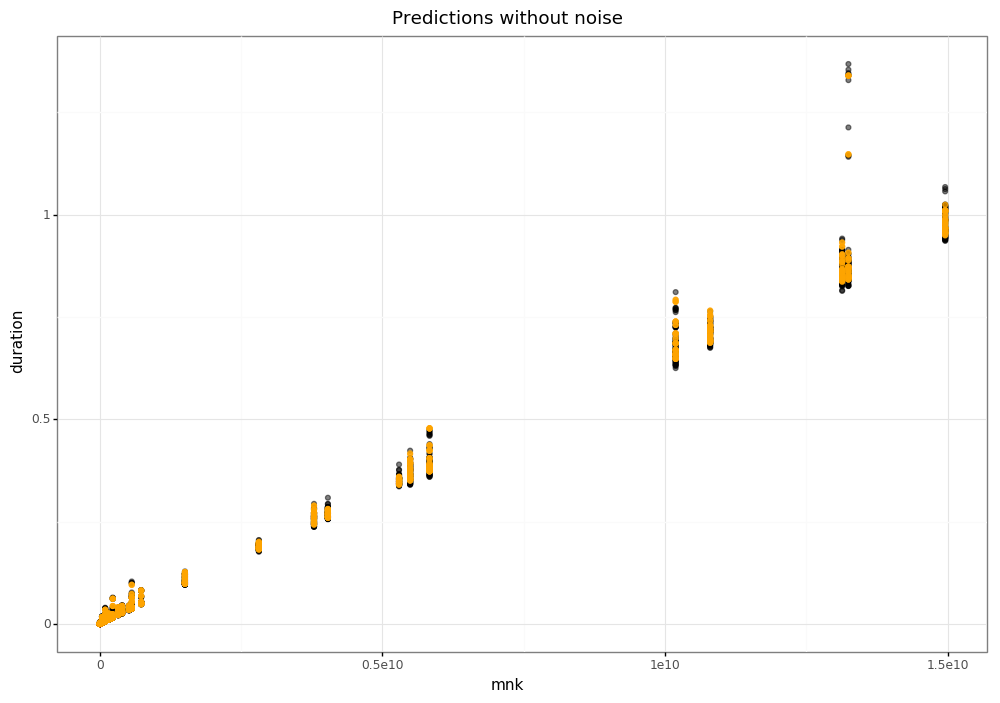

<ggplot: (-9223363245119246781)>


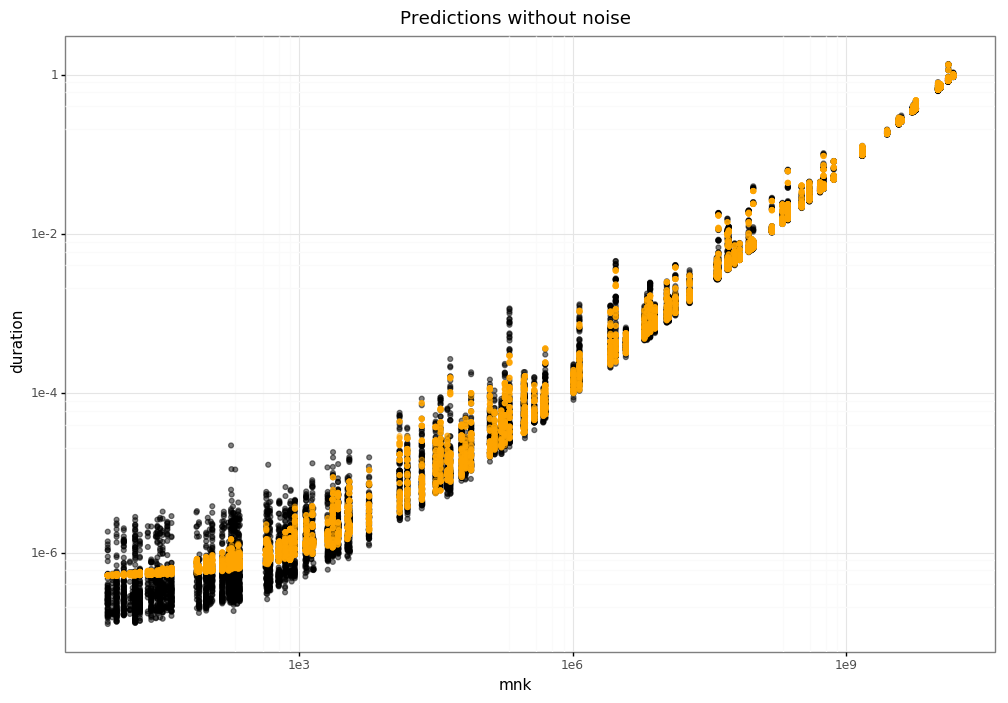

<ggplot: (8791735551871)>


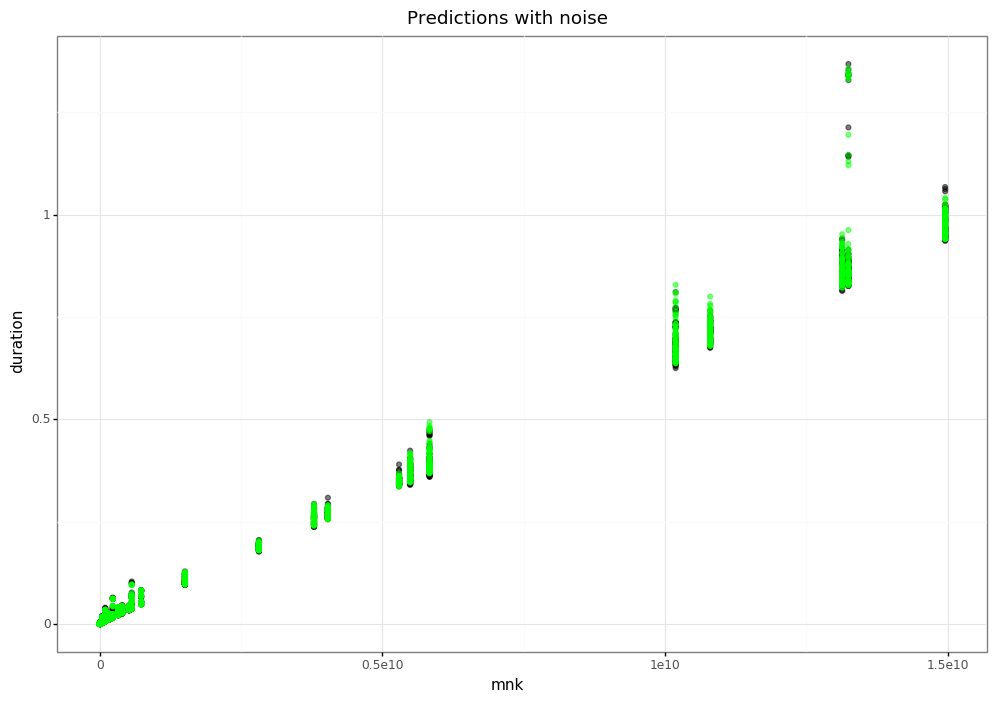

<ggplot: (8791667648534)>


/home/tom/.local/share/virtualenvs/mpi_calibration-tfxxshdH/lib/python3.6/site-packages/plotnine/scales/scale.py:549: RuntimeWarning: invalid value encountered in log10
  return self.trans.transform(x)
/home/tom/.local/share/virtualenvs/mpi_calibration-tfxxshdH/lib/python3.6/site-packages/plotnine/layer.py:449: UserWarning: geom_point : Removed 73 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


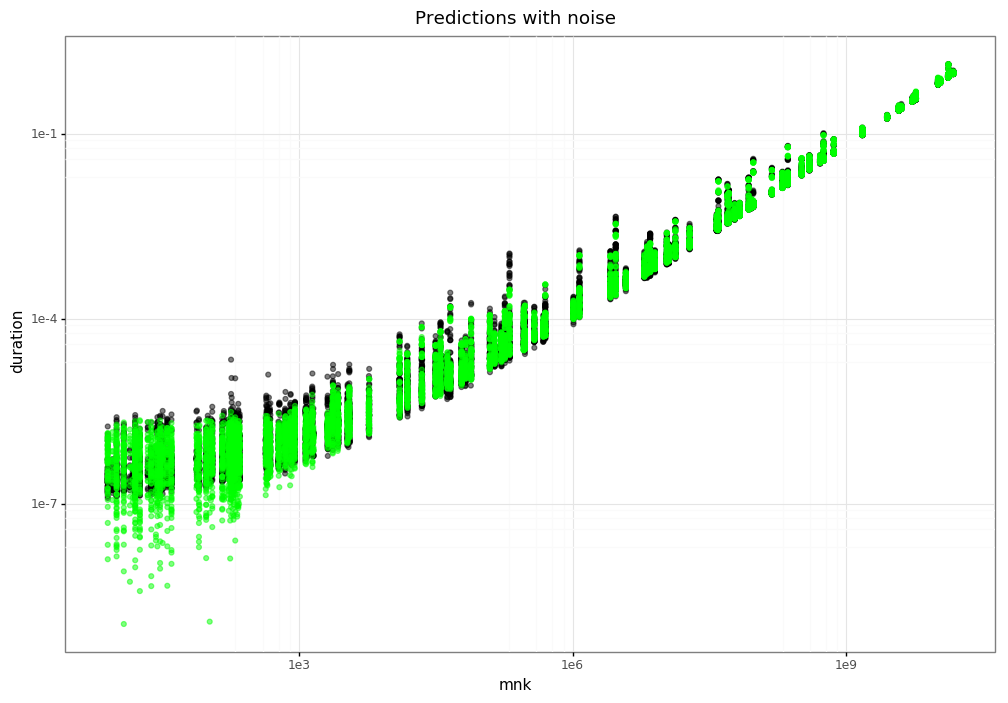

<ggplot: (-9223363245187221518)>
CPU times: user 10.3 s, sys: 5.56 s, total: 15.9 s
Wall time: 12.1 s


{'intercept': 4.936163484059186e-07,
 'mnk': 6.215599907672716e-11,
 'mn': 1.4494828142136615e-10,
 'mk': 2.0536199402634996e-09,
 'nk': 3.2981275203683776e-09,
 'intercept_residual': 4.7264972279171766e-07,
 'mnk_residual': 9.09184958567524e-13,
 'mn_residual': -1.2652343399505341e-11,
 'mk_residual': 6.424634845090486e-11,
 'nk_residual': 1.808557992891291e-11}

In [3]:
from statsmodels.formula.api import ols
import numpy

def compute_intercept(df, x, y):
    short_calls = df[df[x] <= df[x].quantile(0.05)]  # taking the 5% calls with smallest size
    short_calls = short_calls[short_calls[y] < short_calls[y].quantile(0.95)]  # removing the 5% longest calls, we have very large outliers (without this, the intercept is 3 times larger)
    return short_calls[y].mean()

def compute_reg(df, y_var, x_vars, aggregate=False, verbose=False):
    assert 'mnk' in x_vars
    model = '%s ~ %s + 0' % (y_var, ' + '.join(x_vars))
    if verbose:
        print(model)
    df = df.copy()
    if aggregate:
        if aggregate == 'mean':
            df = df.groupby(['m', 'n', 'k'] + x_vars)[[y_var]].mean().reset_index()
        elif aggregate == 'std':
            df = df.groupby(['m', 'n', 'k'] + x_vars)[[y_var]].std().reset_index()
        else:
            assert False
    intercept = max(0, compute_intercept(df, 'mnk', y_var))
    df[y_var] -= intercept
    reg = ols(formula=model, data=df).fit()
    if verbose:
        print(df.head())
        print(reg.summary())
    return {'intercept': intercept, **{var: reg.params[var] for var in x_vars}}

def predict(df, reg, variables):
    pred = numpy.zeros(len(df))
    pred += reg['intercept']
    for var in variables:
        pred += reg[var] * df[var]
    return pred

def compute_full_reg(df, variables, draw_plot=False, verbose=False):
    df = df.copy()
    reg_duration = compute_reg(df, 'duration', variables, aggregate='mean', verbose=verbose)
    df['pred'] = predict(df, reg_duration, variables)
    df['residual'] = df['duration'] - df['pred']
    reg_residual = compute_reg(df, 'residual', variables, aggregate='std', verbose=verbose)
    for k, v in reg_residual.items():
        reg_duration['%s_residual' % k] = reg_residual[k]
    if draw_plot:
        df['sd_noise'] = predict(df, reg_residual, variables)
        df['sigma'] = df['sd_noise']/numpy.sqrt(1-2/numpy.pi)
        df['mu'] = -df['sigma']*numpy.sqrt(2/numpy.pi)
        df['noise'] = numpy.abs(numpy.random.normal(0, 1, len(df)))
        df['noise'] *= df['sigma']
        df['noise'] += df['mu']
        df['pred_noise'] = df['pred'] + df['noise']
        plot = ggplot(df.sample(n=10000), aes(x='mnk')) + geom_point(aes(y='duration'), alpha=0.5) + theme_bw()
        plot1 = plot + geom_point(aes(y='pred'), color='orange', alpha=0.5) + ggtitle('Predictions without noise')
        print(plot1)
        print(plot1 + scale_x_log10() + scale_y_log10())
        plot2 = plot + geom_point(aes(y='pred_noise'), color='lime', alpha=0.5) + ggtitle('Predictions with noise')
        print(plot2)
        print(plot2 + scale_x_log10() + scale_y_log10())
    return reg_duration

%time reg_global = compute_full_reg(df, ['mnk', 'mn', 'mk', 'nk'], draw_plot=True, verbose=True)
reg_global

## Linear model

In [4]:
def compute_reg_percpu(df, variables):
    reg_local = []
    for cpu in sorted(df['cpu'].unique()):
        tmp = df[df['cpu'] == cpu] 
        reg = compute_full_reg(tmp, variables)
        reg['node'] = tmp['node'].unique()[0]
        reg['cpu'] = cpu
        reg_local.append(reg)
    return reg_local

reg_local = compute_reg_percpu(df, ['mnk'])
reg_local_pandas = pandas.DataFrame(reg_local).drop(['node', 'cpu'], 1)
reg_local_pandas.describe()

,intercept,intercept_residual,mnk,mnk_residual
count,5.200000e+01,5.200000e+01,5.200000e+01,5.200000e+01
mean,4.929201e-07,3.914829e-07,6.674615e-11,2.141804e-13
std,1.008978e-08,1.857577e-08,9.228275e-13,1.047567e-13
min,4.759662e-07,3.639953e-07,6.585620e-11,1.221724e-13
25%,4.863071e-07,3.743642e-07,6.632733e-11,1.603062e-13
50%,4.914286e-07,3.891052e-07,6.646294e-11,1.717169e-13
75%,4.958431e-07,4.017451e-07,6.667829e-11,1.938253e-13
max,5.224717e-07,4.425990e-07,7.152829e-11,6.163630e-13


In [5]:
reg_global = {}
for var in reg_local_pandas.columns:
    reg_global[var] = reg_local_pandas[var].mean()
reg_global

{'intercept': 4.929200532312768e-07,
 'intercept_residual': 3.9148288344575526e-07,
 'mnk': 6.674614924272347e-11,
 'mnk_residual': 2.1418044008875768e-13}

In [6]:
def get_reg(reg, residual):
    if residual:
        reg = {k[:-9]: v for k, v in reg.items() if k.endswith('_residual')}
    else:
        reg = {k: v for k, v in reg.items() if not k.endswith('_residual')}
    return reg
    
def model_str(reg, residual=False):
    reg = get_reg(reg, residual)
    parameters = []
    for name, param in reg.items():
        if param == 0:
            continue
        if name != 'intercept':
            parameters.append('%e*%s' % (param, name))
        else:
            parameters.append('%e' % reg[name])
    return ' + '.join(parameters)

def __return_stmt(reg):
    mu    = model_str(reg, False)
    sigma = model_str(reg, True)
    result  = '        double mu    = %s;\n' % mu
    result += '        double sigma = %s;\n' % sigma
    result += '        return mu + random_halfnormal_shifted(0, sigma);'
    return result

def __reg_to_c(reg):
    tmp = dict(reg)
    del tmp['cpu']
    del tmp['node']
    return '''    case %d: // node %d\n%s''' % (reg['cpu'], reg['node'], __return_stmt(tmp))

def reg_to_c(all_reg):
    result = [__reg_to_c(reg) for reg in all_reg]
    return '\n'.join(result)

reg_code = reg_to_c(reg_local)
reg_code = 'switch(get_cpuid()) {\n%s\n    default:\n%s\n}' % (reg_code, __return_stmt(reg_global))

from IPython.display import Markdown, display
display(Markdown('```c\n%s\n```' % reg_code))

```c
switch(get_cpuid()) {
    case 2: // node 1
        double mu    = 5.176631e-07 + 6.807392e-11*mnk;
        double sigma = 4.425990e-07 + 4.599286e-13*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 3: // node 1
        double mu    = 4.868351e-07 + 6.641792e-11*mnk;
        double sigma = 3.832751e-07 + 1.786400e-13*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 4: // node 2
        double mu    = 5.023491e-07 + 6.698288e-11*mnk;
        double sigma = 3.940485e-07 + 2.976445e-13*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 5: // node 2
        double mu    = 4.974726e-07 + 6.667777e-11*mnk;
        double sigma = 3.928921e-07 + 2.171628e-13*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 6: // node 3
        double mu    = 5.033389e-07 + 6.697449e-11*mnk;
        double sigma = 3.950192e-07 + 2.760311e-13*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 7: // node 3
        double mu    = 4.818443e-07 + 6.641611e-11*mnk;
        double sigma = 3.718770e-07 + 1.648001e-13*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 8: // node 4
        double mu    = 4.940256e-07 + 6.638119e-11*mnk;
        double sigma = 4.014520e-07 + 1.700445e-13*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 9: // node 4
        double mu    = 4.811863e-07 + 6.661582e-11*mnk;
        double sigma = 3.639953e-07 + 1.621220e-13*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 12: // node 6
        double mu    = 4.932771e-07 + 6.861956e-11*mnk;
        double sigma = 3.737196e-07 + 4.135677e-13*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 13: // node 6
        double mu    = 4.952999e-07 + 6.610010e-11*mnk;
        double sigma = 3.919210e-07 + 1.417235e-13*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 14: // node 7
        double mu    = 5.042268e-07 + 6.657334e-11*mnk;
        double sigma = 4.045263e-07 + 1.794333e-13*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 15: // node 7
        double mu    = 4.832945e-07 + 6.585620e-11*mnk;
        double sigma = 3.675208e-07 + 1.510313e-13*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 16: // node 8
        double mu    = 4.935647e-07 + 6.765997e-11*mnk;
        double sigma = 3.732866e-07 + 3.760782e-13*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 17: // node 8
        double mu    = 4.924134e-07 + 6.638347e-11*mnk;
        double sigma = 3.891436e-07 + 1.875210e-13*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 18: // node 9
        double mu    = 4.892414e-07 + 6.632665e-11*mnk;
        double sigma = 3.878699e-07 + 1.538359e-13*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 19: // node 9
        double mu    = 4.843786e-07 + 6.632755e-11*mnk;
        double sigma = 3.890611e-07 + 1.603521e-13*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 20: // node 10
        double mu    = 4.947499e-07 + 6.638026e-11*mnk;
        double sigma = 3.890667e-07 + 1.800695e-13*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 21: // node 10
        double mu    = 5.065937e-07 + 6.658042e-11*mnk;
        double sigma = 4.285429e-07 + 1.715758e-13*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 22: // node 11
        double mu    = 4.918953e-07 + 6.616422e-11*mnk;
        double sigma = 3.920778e-07 + 1.535009e-13*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 23: // node 11
        double mu    = 4.882358e-07 + 6.719886e-11*mnk;
        double sigma = 3.714272e-07 + 3.400675e-13*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 24: // node 12
        double mu    = 4.798733e-07 + 6.639145e-11*mnk;
        double sigma = 3.667449e-07 + 1.606275e-13*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 25: // node 12
        double mu    = 4.860476e-07 + 6.618978e-11*mnk;
        double sigma = 3.819153e-07 + 1.742092e-13*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 34: // node 17
        double mu    = 5.124815e-07 + 6.878184e-11*mnk;
        double sigma = 4.265800e-07 + 6.163630e-13*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 35: // node 17
        double mu    = 4.885716e-07 + 6.660915e-11*mnk;
        double sigma = 3.981721e-07 + 1.622225e-13*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 36: // node 18
        double mu    = 5.108739e-07 + 6.845883e-11*mnk;
        double sigma = 4.071176e-07 + 4.991531e-13*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 37: // node 18
        double mu    = 4.820189e-07 + 6.609223e-11*mnk;
        double sigma = 3.871231e-07 + 1.551981e-13*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 38: // node 19
        double mu    = 4.923455e-07 + 6.661056e-11*mnk;
        double sigma = 3.972481e-07 + 1.927498e-13*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 39: // node 19
        double mu    = 4.915001e-07 + 6.642122e-11*mnk;
        double sigma = 3.970659e-07 + 1.687350e-13*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 40: // node 20
        double mu    = 4.847009e-07 + 6.667766e-11*mnk;
        double sigma = 3.793946e-07 + 1.820568e-13*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 41: // node 20
        double mu    = 4.829631e-07 + 6.637330e-11*mnk;
        double sigma = 3.722483e-07 + 1.663763e-13*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 42: // node 21
        double mu    = 4.909472e-07 + 6.667575e-11*mnk;
        double sigma = 3.837337e-07 + 1.970517e-13*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 43: // node 21
        double mu    = 4.890330e-07 + 6.653878e-11*mnk;
        double sigma = 3.936516e-07 + 1.671341e-13*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 44: // node 22
        double mu    = 4.878822e-07 + 6.628636e-11*mnk;
        double sigma = 4.026244e-07 + 1.648943e-13*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 45: // node 22
        double mu    = 4.936822e-07 + 6.647961e-11*mnk;
        double sigma = 3.946072e-07 + 1.736996e-13*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 46: // node 23
        double mu    = 4.941188e-07 + 6.663296e-11*mnk;
        double sigma = 4.121263e-07 + 1.601683e-13*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 47: // node 23
        double mu    = 4.975189e-07 + 6.611012e-11*mnk;
        double sigma = 4.195640e-07 + 1.371572e-13*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 48: // node 24
        double mu    = 4.890067e-07 + 6.644626e-11*mnk;
        double sigma = 3.860074e-07 + 1.543577e-13*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 49: // node 24
        double mu    = 4.926251e-07 + 6.631972e-11*mnk;
        double sigma = 4.090749e-07 + 1.597697e-13*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 50: // node 25
        double mu    = 5.224717e-07 + 7.152829e-11*mnk;
        double sigma = 4.343758e-07 + 4.375335e-13*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 51: // node 25
        double mu    = 4.759662e-07 + 6.597954e-11*mnk;
        double sigma = 3.651041e-07 + 1.221724e-13*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 52: // node 26
        double mu    = 5.071691e-07 + 6.667985e-11*mnk;
        double sigma = 4.156681e-07 + 1.767213e-13*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 53: // node 26
        double mu    = 4.945868e-07 + 6.696900e-11*mnk;
        double sigma = 3.712657e-07 + 2.516303e-13*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 54: // node 27
        double mu    = 5.115211e-07 + 6.690471e-11*mnk;
        double sigma = 4.127484e-07 + 1.839150e-13*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 55: // node 27
        double mu    = 4.846581e-07 + 6.709002e-11*mnk;
        double sigma = 3.716838e-07 + 3.118706e-13*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 58: // node 29
        double mu    = 4.789564e-07 + 6.655724e-11*mnk;
        double sigma = 3.658987e-07 + 1.914987e-13*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 59: // node 29
        double mu    = 5.014018e-07 + 6.667693e-11*mnk;
        double sigma = 4.042239e-07 + 1.896628e-13*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 60: // node 30
        double mu    = 4.864184e-07 + 6.644344e-11*mnk;
        double sigma = 3.745791e-07 + 1.582054e-13*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 61: // node 30
        double mu    = 4.863936e-07 + 6.636593e-11*mnk;
        double sigma = 3.888527e-07 + 1.718579e-13*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 62: // node 31
        double mu    = 4.888675e-07 + 6.618179e-11*mnk;
        double sigma = 3.868797e-07 + 1.409989e-13*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 63: // node 31
        double mu    = 4.858868e-07 + 6.637352e-11*mnk;
        double sigma = 3.734420e-07 + 1.627060e-13*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 64: // node 32
        double mu    = 4.881115e-07 + 6.608004e-11*mnk;
        double sigma = 3.844051e-07 + 1.504486e-13*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 65: // node 32
        double mu    = 4.913571e-07 + 6.616320e-11*mnk;
        double sigma = 3.896617e-07 + 1.611073e-13*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    default:
        double mu    = 4.929201e-07 + 6.674615e-11*mnk;
        double sigma = 3.914829e-07 + 2.141804e-13*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
}
```

## Polynomial model

In [7]:
reg_local_poly = compute_reg_percpu(df, ['mnk', 'mn', 'mk', 'nk'])
reg_local_poly_pandas = pandas.DataFrame(reg_local_poly).drop(['node', 'cpu'], 1)
reg_local_poly_pandas.describe()

,intercept,intercept_residual,mk,mk_residual,mn,mn_residual,mnk,mnk_residual,nk,nk_residual
count,5.200000e+01,5.200000e+01,5.200000e+01,5.200000e+01,5.200000e+01,5.200000e+01,5.200000e+01,5.200000e+01,5.200000e+01,5.200000e+01
mean,4.929201e-07,3.914829e-07,2.053620e-09,4.725869e-11,1.449483e-10,1.284986e-11,6.215600e-11,1.212951e-13,3.298128e-09,5.112152e-11
std,1.008978e-08,1.857577e-08,5.696334e-11,1.059861e-11,2.432386e-11,5.643131e-12,9.056667e-13,1.050219e-13,4.375628e-11,1.422149e-11
min,4.759662e-07,3.639953e-07,1.978105e-09,2.308210e-11,6.192583e-11,-1.437719e-12,6.133599e-11,3.590415e-14,3.177964e-09,2.873476e-11
25%,4.863071e-07,3.743642e-07,2.018813e-09,3.982227e-11,1.458657e-10,1.009292e-11,6.176089e-11,6.170525e-14,3.262540e-09,4.286217e-11
50%,4.914286e-07,3.891052e-07,2.038999e-09,4.762012e-11,1.543641e-10,1.292382e-11,6.186345e-11,7.950777e-14,3.304465e-09,4.933395e-11
75%,4.958431e-07,4.017451e-07,2.080704e-09,5.340303e-11,1.605404e-10,1.582149e-11,6.206019e-11,1.153571e-13,3.324443e-09,5.880044e-11
max,5.224717e-07,4.425990e-07,2.243565e-09,8.140267e-11,1.673913e-10,2.963399e-11,6.684686e-11,5.245396e-13,3.388985e-09,1.202927e-10


In [8]:
reg_global_poly = {}
for var in reg_local_poly_pandas.columns:
    reg_global_poly[var] = reg_local_poly_pandas[var].mean()
reg_global_poly

{'intercept': 4.929200532312768e-07,
 'intercept_residual': 3.9148288344575526e-07,
 'mk': 2.0536199476940307e-09,
 'mk_residual': 4.7258690009076045e-11,
 'mn': 1.4494828885190806e-10,
 'mn_residual': 1.284986400858074e-11,
 'mnk': 6.2155999129456e-11,
 'mnk_residual': 1.2129505272554938e-13,
 'nk': 3.2981275277989067e-09,
 'nk_residual': 5.112151530254675e-11}

In [9]:
reg_code = reg_to_c(reg_local_poly)
reg_code = 'switch(get_cpuid()) {\n%s\n    default:\n%s\n}' % (reg_code, __return_stmt(reg_global_poly))

from IPython.display import Markdown, display
display(Markdown('```c\n%s\n```' % reg_code))

```c
switch(get_cpuid()) {
    case 2: // node 1
        double mu    = 5.176631e-07 + 6.350885e-11*mnk + 9.545662e-11*mn + 2.114035e-09*mk + 3.257169e-09*nk;
        double sigma = 4.425990e-07 + 3.678641e-13*mnk + 1.552287e-11*mn + 3.575659e-11*mk + 5.896758e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 3: // node 1
        double mu    = 4.868351e-07 + 6.184670e-11*mnk + 1.514162e-10*mn + 2.066126e-09*mk + 3.256477e-09*nk;
        double sigma = 3.832751e-07 + 8.351036e-14*mnk + 1.460052e-11*mn + 3.756080e-11*mk + 6.175627e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 4: // node 2
        double mu    = 5.023491e-07 + 6.236673e-11*mnk + 1.316263e-10*mn + 2.080258e-09*mk + 3.315941e-09*nk;
        double sigma = 3.940485e-07 + 2.407008e-13*mnk + 8.341990e-12*mn + 2.953215e-11*mk + 3.031578e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 5: // node 2
        double mu    = 4.974726e-07 + 6.205674e-11*mnk + 1.471030e-10*mn + 2.061982e-09*mk + 3.324590e-09*nk;
        double sigma = 3.928921e-07 + 1.207550e-13*mnk + 1.482112e-11*mn + 4.329756e-11*mk + 5.732950e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 6: // node 3
        double mu    = 5.033389e-07 + 6.232760e-11*mnk + 1.242248e-10*mn + 2.090036e-09*mk + 3.350375e-09*nk;
        double sigma = 3.950192e-07 + 1.985379e-13*mnk + -8.736210e-13*mn + 4.999914e-11*mk + 4.367242e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 7: // node 3
        double mu    = 4.818443e-07 + 6.181782e-11*mnk + 1.464827e-10*mn + 2.049636e-09*mk + 3.310328e-09*nk;
        double sigma = 3.718770e-07 + 5.236684e-14*mnk + 2.055300e-11*mn + 6.184270e-11*mk + 5.224286e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 8: // node 4
        double mu    = 4.940256e-07 + 6.178801e-11*mnk + 1.568555e-10*mn + 2.019072e-09*mk + 3.324394e-09*nk;
        double sigma = 4.014520e-07 + 7.477089e-14*mnk + 1.343630e-11*mn + 4.749938e-11*mk + 5.315425e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 9: // node 4
        double mu    = 4.811863e-07 + 6.201270e-11*mnk + 1.627870e-10*mn + 2.029928e-09*mk + 3.319502e-09*nk;
        double sigma = 3.639953e-07 + 8.976655e-14*mnk + 1.129242e-11*mn + 4.157610e-11*mk + 3.377701e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 12: // node 6
        double mu    = 4.932771e-07 + 6.404389e-11*mnk + 1.094798e-10*mn + 2.115466e-09*mk + 3.254405e-09*nk;
        double sigma = 3.737196e-07 + 3.307311e-13*mnk + 5.095776e-12*mn + 4.167380e-11*mk + 5.242706e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 13: // node 6
        double mu    = 4.952999e-07 + 6.156356e-11*mnk + 1.619846e-10*mn + 2.010381e-09*mk + 3.260128e-09*nk;
        double sigma = 3.919210e-07 + 4.685596e-14*mnk + 1.597936e-11*mn + 5.314991e-11*mk + 4.447439e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 14: // node 7
        double mu    = 5.042268e-07 + 6.194369e-11*mnk + 1.547242e-10*mn + 2.072948e-09*mk + 3.316321e-09*nk;
        double sigma = 4.045263e-07 + 6.879347e-14*mnk + 1.617777e-11*mn + 5.380012e-11*mk + 6.251309e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 15: // node 7
        double mu    = 4.832945e-07 + 6.133599e-11*mnk + 1.617922e-10*mn + 1.987801e-09*mk + 3.263344e-09*nk;
        double sigma = 3.675208e-07 + 5.961817e-14*mnk + 1.239695e-11*mn + 5.125212e-11*mk + 4.581797e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 16: // node 8
        double mu    = 4.935647e-07 + 6.305588e-11*mnk + 8.097412e-11*mn + 2.136391e-09*mk + 3.296024e-09*nk;
        double sigma = 3.732866e-07 + 3.074514e-13*mnk + -1.437719e-12*mn + 5.488336e-11*mk + 2.873476e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 17: // node 8
        double mu    = 4.924134e-07 + 6.185977e-11*mnk + 1.539445e-10*mn + 2.020350e-09*mk + 3.242825e-09*nk;
        double sigma = 3.891436e-07 + 9.336698e-14*mnk + 1.088144e-11*mn + 5.702408e-11*mk + 4.484375e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 18: // node 9
        double mu    = 4.892414e-07 + 6.171223e-11*mnk + 1.595345e-10*mn + 2.034004e-09*mk + 3.332226e-09*nk;
        double sigma = 3.878699e-07 + 4.386713e-14*mnk + 1.441969e-11*mn + 5.279831e-11*mk + 6.446940e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 19: // node 9
        double mu    = 4.843786e-07 + 6.179913e-11*mnk + 1.555239e-10*mn + 2.000865e-09*mk + 3.266388e-09*nk;
        double sigma = 3.890611e-07 + 6.240094e-14*mnk + 1.385222e-11*mn + 4.388016e-11*mk + 5.956400e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 20: // node 10
        double mu    = 4.947499e-07 + 6.177217e-11*mnk + 1.574658e-10*mn + 2.028801e-09*mk + 3.331912e-09*nk;
        double sigma = 3.890667e-07 + 1.007106e-13*mnk + 1.003245e-11*mn + 3.787737e-11*mk + 4.712221e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 21: // node 10
        double mu    = 5.065937e-07 + 6.194689e-11*mnk + 1.482196e-10*mn + 2.040617e-09*mk + 3.359802e-09*nk;
        double sigma = 4.285429e-07 + 7.958848e-14*mnk + 1.011307e-11*mn + 5.080979e-11*mk + 4.923180e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 22: // node 11
        double mu    = 4.918953e-07 + 6.166460e-11*mnk + 1.557420e-10*mn + 1.995393e-09*mk + 3.237157e-09*nk;
        double sigma = 3.920778e-07 + 6.835200e-14*mnk + 1.274438e-11*mn + 4.930389e-11*mk + 3.991733e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 23: // node 11
        double mu    = 4.882358e-07 + 6.259746e-11*mnk + 1.026824e-10*mn + 2.133298e-09*mk + 3.274179e-09*nk;
        double sigma = 3.714272e-07 + 2.486803e-13*mnk + 9.217720e-12*mn + 6.577017e-11*mk + 3.444806e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 24: // node 12
        double mu    = 4.798733e-07 + 6.180736e-11*mnk + 1.619451e-10*mn + 2.024514e-09*mk + 3.302979e-09*nk;
        double sigma = 3.667449e-07 + 5.482824e-14*mnk + 1.475172e-11*mn + 6.180322e-11*mk + 5.013946e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 25: // node 12
        double mu    = 4.860476e-07 + 6.169386e-11*mnk + 1.533953e-10*mn + 1.981956e-09*mk + 3.248501e-09*nk;
        double sigma = 3.819153e-07 + 1.135578e-13*mnk + 6.770309e-12*mn + 3.140087e-11*mk + 3.445871e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 34: // node 17
        double mu    = 5.124815e-07 + 6.416433e-11*mnk + 9.647405e-11*mn + 2.198422e-09*mk + 3.234558e-09*nk;
        double sigma = 4.265800e-07 + 5.245396e-13*mnk + 2.282277e-11*mn + 2.308210e-11*mk + 6.405347e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 35: // node 17
        double mu    = 4.885716e-07 + 6.196703e-11*mnk + 1.517621e-10*mn + 2.082042e-09*mk + 3.325126e-09*nk;
        double sigma = 3.981721e-07 + 3.590415e-14*mnk + 1.902220e-11*mn + 5.693618e-11*mk + 7.530758e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 36: // node 18
        double mu    = 5.108739e-07 + 6.392515e-11*mnk + 6.192583e-11*mn + 2.189185e-09*mk + 3.177964e-09*nk;
        double sigma = 4.071176e-07 + 3.893158e-13*mnk + 2.963399e-11*mn + 4.066395e-11*mk + 6.123203e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 37: // node 18
        double mu    = 4.820189e-07 + 6.158827e-11*mnk + 1.616031e-10*mn + 1.994777e-09*mk + 3.237100e-09*nk;
        double sigma = 3.871231e-07 + 8.158790e-14*mnk + 9.505923e-12*mn + 4.721878e-11*mk + 3.142333e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 38: // node 19
        double mu    = 4.923455e-07 + 6.196489e-11*mnk + 1.543992e-10*mn + 2.057428e-09*mk + 3.351357e-09*nk;
        double sigma = 3.972481e-07 + 8.658301e-14*mnk + 1.747657e-11*mn + 5.091317e-11*mk + 5.874473e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 39: // node 19
        double mu    = 4.915001e-07 + 6.183613e-11*mnk + 1.534767e-10*mn + 2.034158e-09*mk + 3.303009e-09*nk;
        double sigma = 3.970659e-07 + 7.572456e-14*mnk + 1.091060e-11*mn + 3.755636e-11*mk + 6.291291e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 40: // node 20
        double mu    = 4.847009e-07 + 6.204414e-11*mnk + 1.578919e-10*mn + 2.090352e-09*mk + 3.300387e-09*nk;
        double sigma = 3.793946e-07 + 7.942706e-14*mnk + 1.671621e-11*mn + 5.365856e-11*mk + 5.252419e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 41: // node 20
        double mu    = 4.829631e-07 + 6.179681e-11*mnk + 1.482244e-10*mn + 2.038635e-09*mk + 3.293478e-09*nk;
        double sigma = 3.722483e-07 + 8.793656e-14*mnk + 9.969439e-12*mn + 3.742316e-11*mk + 4.653886e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 42: // node 21
        double mu    = 4.909472e-07 + 6.200865e-11*mnk + 1.543290e-10*mn + 2.052205e-09*mk + 3.382308e-09*nk;
        double sigma = 3.837337e-07 + 7.486165e-14*mnk + 1.804121e-11*mn + 8.140267e-11*mk + 4.687852e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 43: // node 21
        double mu    = 4.890330e-07 + 6.192177e-11*mnk + 1.573438e-10*mn + 2.051455e-09*mk + 3.320061e-09*nk;
        double sigma = 3.936516e-07 + 5.312143e-14*mnk + 1.572031e-11*mn + 6.261635e-11*mk + 5.819328e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 44: // node 22
        double mu    = 4.878822e-07 + 6.172976e-11*mnk + 1.482621e-10*mn + 2.028372e-09*mk + 3.279886e-09*nk;
        double sigma = 4.026244e-07 + 7.197645e-14*mnk + 1.082554e-11*mn + 5.178771e-11*mk + 4.865570e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 45: // node 22
        double mu    = 4.936822e-07 + 6.186714e-11*mnk + 1.543108e-10*mn + 2.052711e-09*mk + 3.316411e-09*nk;
        double sigma = 3.946072e-07 + 8.449272e-14*mnk + 1.064643e-11*mn + 3.933274e-11*mk + 5.684593e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 46: // node 23
        double mu    = 4.941188e-07 + 6.198228e-11*mnk + 1.545497e-10*mn + 2.033903e-09*mk + 3.380732e-09*nk;
        double sigma = 4.121263e-07 + 6.894363e-14*mnk + 1.158814e-11*mn + 4.405521e-11*mk + 5.359804e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 47: // node 23
        double mu    = 4.975189e-07 + 6.154566e-11*mnk + 1.625192e-10*mn + 2.018039e-09*mk + 3.285374e-09*nk;
        double sigma = 4.195640e-07 + 4.712705e-14*mnk + 1.683734e-11*mn + 4.785140e-11*mk + 4.312214e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 48: // node 24
        double mu    = 4.890067e-07 + 6.185867e-11*mnk + 1.613742e-10*mn + 2.021834e-09*mk + 3.310428e-09*nk;
        double sigma = 3.860074e-07 + 4.992063e-14*mnk + 1.860987e-11*mn + 4.774086e-11*mk + 5.871249e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 49: // node 24
        double mu    = 4.926251e-07 + 6.173476e-11*mnk + 1.621909e-10*mn + 2.039362e-09*mk + 3.288933e-09*nk;
        double sigma = 4.090749e-07 + 5.865557e-14*mnk + 1.463527e-11*mn + 6.486346e-11*mk + 4.158526e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 50: // node 25
        double mu    = 5.224717e-07 + 6.684686e-11*mnk + 9.476546e-11*mn + 2.243565e-09*mk + 3.267669e-09*nk;
        double sigma = 4.343758e-07 + 2.947679e-13*mnk + 1.967469e-11*mn + 3.099421e-11*mk + 1.202927e-10*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 51: // node 25
        double mu    = 4.759662e-07 + 6.142307e-11*mnk + 1.666604e-10*mn + 1.978105e-09*mk + 3.311607e-09*nk;
        double sigma = 3.651041e-07 + 4.321739e-14*mnk + 1.196260e-11*mn + 4.376371e-11*mk + 3.882221e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 52: // node 26
        double mu    = 5.071691e-07 + 6.203203e-11*mnk + 1.440150e-10*mn + 2.060903e-09*mk + 3.360838e-09*nk;
        double sigma = 4.156681e-07 + 1.026177e-13*mnk + 6.671157e-12*mn + 3.998545e-11*mk + 4.208227e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 53: // node 26
        double mu    = 4.945868e-07 + 6.233651e-11*mnk + 1.172611e-10*mn + 2.124213e-09*mk + 3.305920e-09*nk;
        double sigma = 3.712657e-07 + 1.648723e-13*mnk + 5.609670e-12*mn + 5.424832e-11*mk + 4.403454e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 54: // node 27
        double mu    = 5.115211e-07 + 6.221490e-11*mnk + 1.418988e-10*mn + 2.085160e-09*mk + 3.388985e-09*nk;
        double sigma = 4.127484e-07 + 8.150039e-14*mnk + 1.576886e-11*mn + 5.331785e-11*mk + 5.355455e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 55: // node 27
        double mu    = 4.846581e-07 + 6.244143e-11*mnk + 1.171356e-10*mn + 2.127831e-09*mk + 3.321703e-09*nk;
        double sigma = 3.716838e-07 + 2.154875e-13*mnk + 6.279426e-12*mn + 4.683788e-11*mk + 6.230127e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 58: // node 29
        double mu    = 4.789564e-07 + 6.196234e-11*mnk + 1.525791e-10*mn + 2.013158e-09*mk + 3.336648e-09*nk;
        double sigma = 3.658987e-07 + 1.291703e-13*mnk + 2.057693e-12*mn + 3.168401e-11*mk + 4.089649e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 59: // node 29
        double mu    = 5.014018e-07 + 6.207055e-11*mnk + 1.559168e-10*mn + 2.048223e-09*mk + 3.311984e-09*nk;
        double sigma = 4.042239e-07 + 1.007000e-13*mnk + 1.496691e-11*mn + 4.434940e-11*mk + 4.721640e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 60: // node 30
        double mu    = 4.864184e-07 + 6.184368e-11*mnk + 1.602625e-10*mn + 2.029841e-09*mk + 3.318098e-09*nk;
        double sigma = 3.745791e-07 + 4.860992e-14*mnk + 1.490017e-11*mn + 5.429349e-11*mk + 6.204667e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 61: // node 30
        double mu    = 4.863936e-07 + 6.185760e-11*mnk + 1.619071e-10*mn + 1.998977e-09*mk + 3.237839e-09*nk;
        double sigma = 3.888527e-07 + 7.220267e-14*mnk + 2.159438e-11*mn + 4.859564e-11*mk + 4.914690e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 62: // node 31
        double mu    = 4.888675e-07 + 6.163329e-11*mnk + 1.596314e-10*mn + 2.008430e-09*mk + 3.278759e-09*nk;
        double sigma = 3.868797e-07 + 5.425850e-14*mnk + 1.243494e-11*mn + 5.090185e-11*mk + 4.053472e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 63: // node 31
        double mu    = 4.858868e-07 + 6.176961e-11*mnk + 1.619049e-10*mn + 2.019454e-09*mk + 3.331812e-09*nk;
        double sigma = 3.734420e-07 + 6.591220e-14*mnk + 1.310326e-11*mn + 4.231096e-11*mk + 6.049612e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 64: // node 32
        double mu    = 4.881115e-07 + 6.158081e-11*mnk + 1.619842e-10*mn + 1.985753e-09*mk + 3.240081e-09*nk;
        double sigma = 3.844051e-07 + 7.794425e-14*mnk + 1.042054e-11*mn + 3.865148e-11*mk + 3.775177e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 65: // node 32
        double mu    = 4.913571e-07 + 6.164220e-11*mnk + 1.673913e-10*mn + 1.987885e-09*mk + 3.258608e-09*nk;
        double sigma = 3.896617e-07 + 7.888882e-14*mnk + 1.109705e-11*mn + 3.792334e-11*mk + 4.943609e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    default:
        double mu    = 4.929201e-07 + 2.053620e-09*mk + 1.449483e-10*mn + 6.215600e-11*mnk + 3.298128e-09*nk;
        double sigma = 3.914829e-07 + 4.725869e-11*mk + 1.284986e-11*mn + 1.212951e-13*mnk + 5.112152e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
}
```

### Visualization (linear model)

In [10]:
def compute_predictions(df, reg_local, variables):
    for reg in reg_local:
        tmp = df[df['cpu'] == reg['cpu']]
        reg_duration = get_reg(reg, residual=False)
        df.loc[df['cpu'] == reg['cpu'], 'prediction'] = predict(tmp, reg_duration, variables)
        reg_residual = get_reg(reg, residual=True)
        df.loc[df['cpu'] == reg['cpu'], 'sd_noise'] = predict(tmp, reg_residual, variables)
    df['sigma'] = df['sd_noise']/numpy.sqrt(1-2/numpy.pi)
    df['mu'] = -df['sigma']*numpy.sqrt(2/numpy.pi)
    df['noise'] = numpy.abs(numpy.random.normal(0, 1, len(df)))
    df['noise'] *= df['sigma']
    df['noise'] += df['mu']
    df['pred_noise'] = df['prediction'] + df['noise']

compute_predictions(df, reg_local, ['mnk'])
df.head()

,function,m,n,k,timestamp,duration,node,index,index_in_seq,first_index,...,mnk,mn,mk,nk,prediction,sd_noise,sigma,mu,noise,pred_noise
0,dgemm,6,230,44,1163.904496,3.712100e-05,2,0,0,True,...,60720,1380,264,10120,4.569549e-06,4.121215e-07,6.836670e-07,-5.454873e-07,1.242493e-07,4.693799e-06
1,dgemm,6,230,44,1163.904557,1.693200e-05,2,1,1,False,...,60720,1380,264,10120,4.569549e-06,4.121215e-07,6.836670e-07,-5.454873e-07,-3.347161e-07,4.234833e-06
2,dgemm,6,230,44,1163.904576,2.938100e-05,2,2,2,False,...,60720,1380,264,10120,4.569549e-06,4.121215e-07,6.836670e-07,-5.454873e-07,1.037673e-07,4.673317e-06
3,dgemm,5,46,2,1163.904608,2.062000e-06,2,3,0,True,...,460,230,10,92,5.331612e-07,3.941854e-07,6.539129e-07,-5.217470e-07,7.790067e-07,1.312168e-06
4,dgemm,5,46,2,1163.904612,7.150000e-07,2,4,1,False,...,460,230,10,92,5.331612e-07,3.941854e-07,6.539129e-07,-5.217470e-07,2.484647e-07,7.816259e-07


In [11]:
tmp = df.melt(id_vars=['cpu', 'node', 'mnk'], value_vars=['duration', 'pred_noise'])
tmp.head()

,cpu,node,mnk,variable,value
0,4,2,60720,duration,3.712100e-05
1,4,2,60720,duration,1.693200e-05
2,4,2,60720,duration,2.938100e-05
3,4,2,460,duration,2.062000e-06
4,4,2,460,duration,7.150000e-07


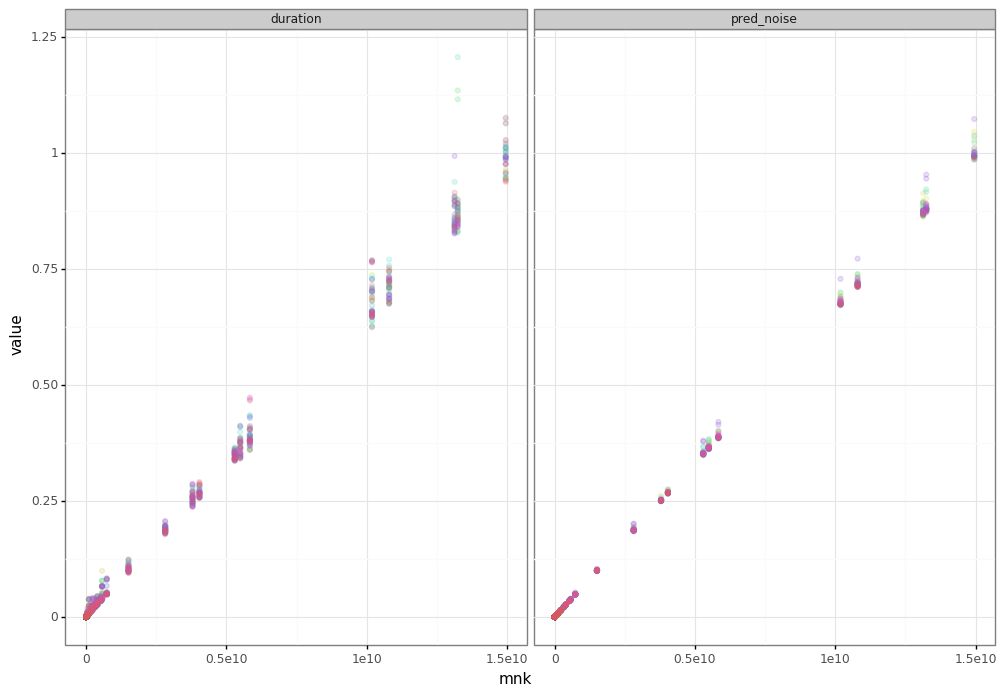

<ggplot: (8791735561725)>


/home/tom/.local/share/virtualenvs/mpi_calibration-tfxxshdH/lib/python3.6/site-packages/plotnine/scales/scale.py:549: RuntimeWarning: invalid value encountered in log10
  return self.trans.transform(x)
/home/tom/.local/share/virtualenvs/mpi_calibration-tfxxshdH/lib/python3.6/site-packages/plotnine/layer.py:449: UserWarning: geom_point : Removed 18 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


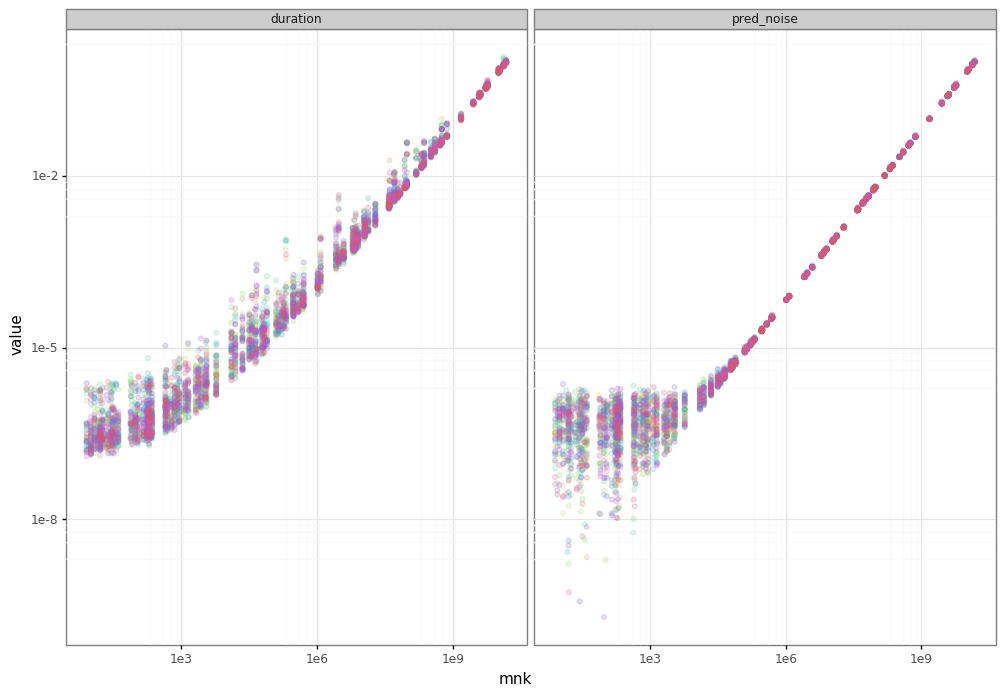

<ggplot: (8791667182358)>


In [12]:
plot = ggplot(tmp.sample(n=10000), aes(x='mnk', y='value', color='factor(cpu)')) + geom_point(alpha=0.2) + theme_bw() + facet_wrap('variable') + scale_color_discrete(guide=False)
print(plot)
print(plot + scale_x_log10() + scale_y_log10())

### Visualization (polynomial model)

In [13]:
compute_predictions(df, reg_local_poly, ['mnk', 'mn', 'mk', 'nk'])
df.head()

,function,m,n,k,timestamp,duration,node,index,index_in_seq,first_index,...,mnk,mn,mk,nk,prediction,sd_noise,sigma,mu,noise,pred_noise
0,dgemm,6,230,44,1163.904496,3.712100e-05,2,0,0,True,...,60720,1380,264,10120,3.857741e-05,7.347680e-07,1.218904e-06,-9.725449e-07,-6.230099e-07,3.795440e-05
1,dgemm,6,230,44,1163.904557,1.693200e-05,2,1,1,False,...,60720,1380,264,10120,3.857741e-05,7.347680e-07,1.218904e-06,-9.725449e-07,-1.410934e-07,3.843631e-05
2,dgemm,6,230,44,1163.904576,2.938100e-05,2,2,2,False,...,60720,1380,264,10120,3.857741e-05,7.347680e-07,1.218904e-06,-9.725449e-07,3.288783e-07,3.890629e-05
3,dgemm,5,46,2,1163.904608,2.062000e-06,2,3,0,True,...,460,230,10,92,8.871809e-07,3.991623e-07,6.621690e-07,-5.283344e-07,-3.828133e-07,5.043676e-07
4,dgemm,5,46,2,1163.904612,7.150000e-07,2,4,1,False,...,460,230,10,92,8.871809e-07,3.991623e-07,6.621690e-07,-5.283344e-07,-7.802394e-08,8.091570e-07


In [14]:
tmp = df.melt(id_vars=['cpu', 'node', 'mnk'], value_vars=['duration', 'pred_noise'])
tmp.head()

,cpu,node,mnk,variable,value
0,4,2,60720,duration,3.712100e-05
1,4,2,60720,duration,1.693200e-05
2,4,2,60720,duration,2.938100e-05
3,4,2,460,duration,2.062000e-06
4,4,2,460,duration,7.150000e-07


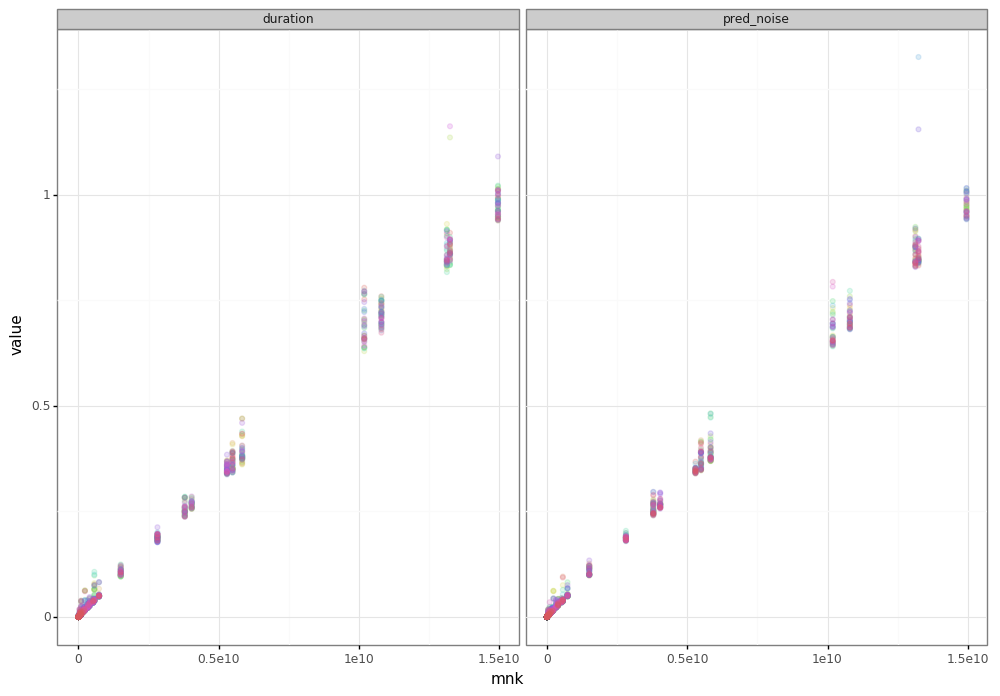

<ggplot: (-9223363245221586905)>


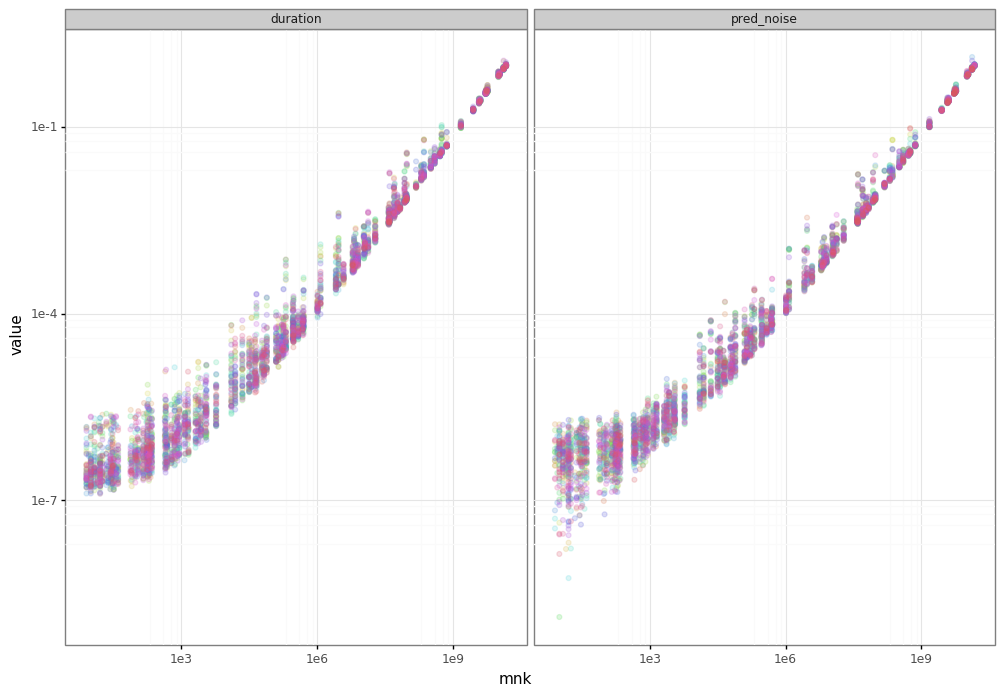

<ggplot: (8791633003405)>


In [15]:
plot = ggplot(tmp.sample(n=10000), aes(x='mnk', y='value', color='factor(cpu)')) + geom_point(alpha=0.2) + theme_bw() + facet_wrap('variable') + scale_color_discrete(guide=False)
print(plot)
print(plot + scale_x_log10() + scale_y_log10())